In [4]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import numpy as np
%matplotlib inline

# swap test overlap circuit (psi ancilla)

In [20]:
def normalize(v):
    return v / np.linalg.norm(v)


def calc_z(a, b) -> float:
    ''' z = |a|**2 + |b|**2 '''
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    return a_mag**2 + b_mag**2


def psi_amp(a, b):
    ''' prepare amplitudes for state psi '''
    
    a_norm = normalize(a)
    b_norm = normalize(b)

    # import ipdb; ipdb.set_trace()
    
    return np.hstack([a_norm, b_norm]) * (1/np.sqrt(2))


def phi_amp(a, b):
    ''' prepare amplitudes for state phi '''

    z = calc_z(a, b)
    a_mag =  np.linalg.norm(a)
    b_mag =  np.linalg.norm(b)
    
    return np.hstack([a_mag, -b_mag])/np.sqrt(z)


def psi_circuit(a, b):

    amp = psi_amp(a, b) # 2*n amplitudes 1/sqrt(2) (a0, ..., an, b0, ..., bn)
    sz = int(np.log2(len(amp)))
    
    qc = QuantumCircuit(sz, name=r'$\psi$ prep  ') # 2 qubits if a,b in R^2

    qc.initialize(amp, range(sz))
    
    return qc


def phi_circuit(a, b) -> QuantumCircuit:
    ''' prepare subcircuit for state phi '''

    amp = phi_amp(a, b) # 2 amplitudes 1/sqrt(z) (|a|, |b|)
    sz = 1 # always 2 amplitudes
    
    qc = QuantumCircuit(sz, name=r'$\phi$ prep  ') # 2 qubits if a,b in R^2

    qc.initialize(amp, [0])
    
    return qc

In [30]:
def overlap_circuit(a, b) -> QuantumCircuit:
    ''' full overlap circuit < phi | psi > '''
    n = len(a)
    if not ((n & (n-1) == 0) and n != 0):
        raise ValueError("size of input vectors must be power of 2 but is " + str(n))
    
    psi = psi_circuit(a, b)
    phi = phi_circuit(a, b)
    
    anc = QuantumRegister(1, 'anc')
    qr_psi = QuantumRegister(psi.width(), 'psi')
    qr_phi = QuantumRegister(phi.width(), 'phi')
    cr = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(anc, qr_psi, qr_phi, cr)
    
    qc.append(psi, qr_psi[:])
    qc.append(phi, qr_phi[:])
    
    qc.barrier()
    
    qc.h(0)
    qc.cswap(0, qr_psi[-1], qr_phi[0]) # perform test on psi ancilla alone
    qc.h(0)
    
    qc.measure(0,0)
    
    return qc

In [31]:
qc = overlap_circuit([1,3],[6,7])

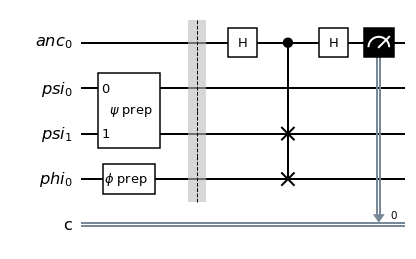

In [32]:
qc.draw("mpl", style="bw")

# Oracles

In [5]:
def create_threshold_oracle(nn, idcs_to_mark):
    
    # create the identity matrix on n qubits
    oracle_matrix = np.identity(2**nn)
    # add the -1 phase to marked elements
    for idx in idcs_to_mark:
        oracle_matrix[idx, idx] = -1
        
    # convert oracle_matrix into an operator, and add it to the quantum circuit
    op = Operator(oracle_matrix)
    
    # create a quantum circuit on nn qubits
    qc = QuantumCircuit(nn, name='oracle')
    
    # import ipdb; ipdb.set_trace()    
    # convert oracle_matrix into an operator, and add it to the quantum circuit
    qc.unitary(op, range(nn))
    return qc

# Grover

In [17]:
from qiskit.quantum_info.operators import Operator, Pauli

def diffuser(n):
    
    qc = QuantumCircuit(n)
    
    # Apply a H-gate to all qubits (transformation |s> -> |00..0>)
    # Followed by X-gate (transformation |00..0> -> |11..1>)
    for q in range(n):
        qc.h(q)
        qc.x(q)
        
    # Do multi-controlled-Z gate
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli
    qc.h(n-1)
    
    # Apply transformation |11..1> -> |00..0>
    # Apply transformation |00..0> -> |s>
    for q in range(n):
        qc.x(q)
        qc.h(q)

    # Convert diffuser to gate
    diff_gate = qc.to_gate()
    diff_gate.name = "diffuser"
    
    return diff_gate


def grover_circuit(n, oracle, marked_n=1):
    
    qc = QuantumCircuit(n,n)

    # Determine r
    r = int(np.floor(np.pi/4*np.sqrt(2**n/marked_n))) if marked_n else 0
    
    # Apply a H-gate to all qubits
    for q in range(n):
        qc.h(q)

    qc.barrier()
    
    for _ in range(r):
        # add oracle
        qc.append(oracle, range(n))   
        # add diffuser
        qc.append(diffuser(n), range(n))
    
    qc.barrier()
    
    # step 3: measure all qubits
    qc.measure(range(n), range(n))
  
    return qc

In [21]:
nn = 2 # 2 qubits (4 dimensional latent space)
idcs_to_mark = [1] # |01> is winner
ora_qc = create_threshold_oracle(nn, idcs_to_mark)

In [22]:
marked_n = 1
grover_qc = grover_circuit(nn, ora_qc, marked_n)

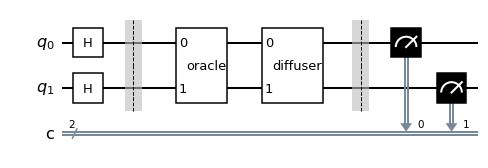

In [23]:
grover_qc.draw("mpl", style="bw")